# Building a regression model
A regression model will be constructed using the Kaggle `avocado` dataset. For estimating the model's coefficients, the ordinary least squares method will be used, via `statsmodels.regression.linear_model.OLS`.

### Linear regression
Assumptions of linear regression:
- Normality
- Homoscedasticity 
- Linear dependency 

### Import libraries and read in dataset

In [2]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sb
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("avocado.csv")
df.columns

Index(['Unnamed: 0', 'Date', 'AveragePrice', 'Total Volume', '4046', '4225',
       '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type',
       'year', 'region'],
      dtype='object')

# Data exploration
## Normality and transformation
The first assumption of regression is normality firstly of the dependent variable. Normality will be established using the following methods:
- Visual representation with a histogram, a rug plot and a density plot. This should show a bell curve shape 
- Kolmogorov Smirnov test and Anderson test with assumption of normality. This is done with `scipy.stats.anderson` and `scipy.stats.kstest`. The Shapiro-Wilk test was not used because of the size of the dataset. If the p-value for these tests is greater than a decided threshold (0.05), this means that the null hypothesis can be accepted.
- If both steps above indicate normality, finally a `Q-Q plot` can be drawn to confirm the hypothesis. This is done using `stats.probplot(data, dist="norm", plot=plt)`


In [4]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex_axis(d.columns, 1).agg(stats))

describe(df, ['skew', 'mad', 'kurt'])['AveragePrice']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


count    18249.000000
mean         1.405978
std          0.402677
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.250000
skew         0.580303
mad          0.324280
kurt         0.325196
Name: AveragePrice, dtype: float64

p-value for kolmogorov test: 5.400984145248518e-18
p-value for anderson test: 0.787


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


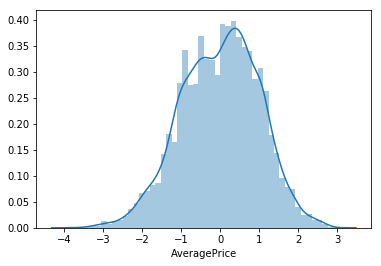

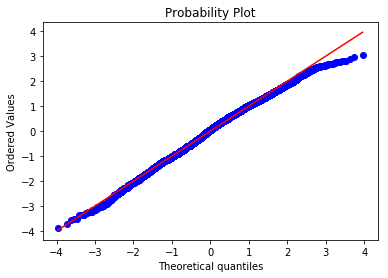

In [5]:
# Establish normality
from scipy.stats import kstest, anderson, probplot

# Scale values - kolmogorov smirnov checks standard normal
# to normalise values, subtract by mean and divide over sigma
x = np.log(df['AveragePrice'])
x = (x - x.mean())/(x.std())

# Take the second value (p-value) from the kolmogorov
# normality test
k = kstest(x, 'norm')[1]
print("p-value for kolmogorov test:", k)

# Take the third critical value (5%) from the anderson 
# normality test
a = anderson(x, dist='norm').critical_values[2]
print("p-value for anderson test:", a)

# Visual representation 
sb.distplot(x)
plt.show()

# Q-Q plot 
probplot(x, dist="norm", plot=plt)
plt.show()

Because the average price data does not show signs of normality, logarithmic transformation was used.

The Q-Q plot looks acceptable but the histogram shows two peaks in the data, despite the smoothing and the rescaling performed. 
The anderson test gives an acceptable result to assume normality but the kstest gives an extremely small value and the null hypothesis cannot be accepted. Different subsets will be explored to find possible normality in other parts of the data.

## Establishing subset normality
Exploring different subsets of the data, the subset of avocados for 2018 showed a normal distribution. Therefore the 2018 subset will be rescaled and used as a baseline for the regression model.

In [269]:
# Scale the data
df['AveragePrice'] = (df['AveragePrice'] - df['AveragePrice'].mean())/(df['AveragePrice'].std())

# Get 2018 subset
df = df[df['year'] == 2018]

# Scale data again
df['AveragePrice'] = (df['AveragePrice'] - df['AveragePrice'].mean())/(df['AveragePrice'].std())

Kolmogorov p-value: 0.26429950050529927
Kolmogorov p-value: 0.785


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


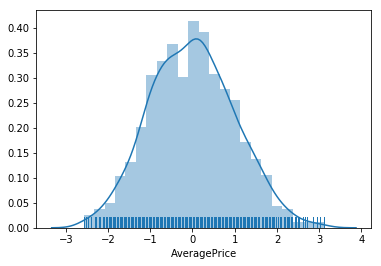

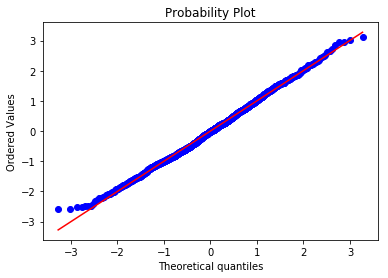

In [270]:
k = stats.kstest(df['AveragePrice'], cdf='norm')[1]
a = stats.anderson(df['AveragePrice'], dist='norm').critical_values[2]

print("Kolmogorov p-value:", k)
print("Kolmogorov p-value:", a)

sb.distplot(df['AveragePrice'], kde = True, rug = True)
plt.show()

# Q-Q plot 
stats.probplot(df['AveragePrice'], dist="norm", plot=plt)
plt.show()

In [271]:
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex_axis(d.columns, 1).agg(stats))

describe(df, ['skew', 'mad', 'kurt'])['AveragePrice']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


count    1.296000e+03
mean     2.604227e-17
std      1.000000e+00
min     -2.574827e+00
25%     -7.112158e-01
50%     -8.274645e-03
75%      6.946665e-01
max      3.114092e+00
skew     1.356921e-01
mad      8.053651e-01
kurt    -2.037141e-01
Name: AveragePrice, dtype: float64

The Q-Q plot shows a slight tail on the bottom half but overall the the p-values, the plots and the graph all confirm normality.

# Chi squared independence test
**Null hypothesis**: Assumes that there is no association between two variables. 

This test will be performed on a few categorical variables within the dataset to establish independence. If independence is established, they will be used in the regression model.

In [272]:
# Define a helper function for a chi-squared test
# this tests the null hypothesis that the two variables are independent 
def chi_squared(col1, col2):
    # Get the test results
    p = stats.chi2_contingency(pd.crosstab(index=df[col1], columns=df[col2]))[1]
    print("Looking for independence between", col1, "and", col2)
    
    # Print a message 
    if p > 0.05:
        print("p-value for chi squared test:", p,  "> 0.05")
        print("Variables are independent\n")
    else: 
        print("p-value for chi squared test:", p, "< 0.05")
        print("Variables are dependent\n")

In [273]:
chi_squared('year', 'region')
chi_squared('year', 'type')
chi_squared('region', 'type')

Looking for independence between year and region
p-value for chi squared test: 1.0 > 0.05
Variables are independent

Looking for independence between year and type
p-value for chi squared test: 1.0 > 0.05
Variables are independent

Looking for independence between region and type
p-value for chi squared test: 1.0 > 0.05
Variables are independent



All variables are independent and will be used within the model.

# Regression model
To build the regression model, first the categorical variables will be used. Next, random numeric variables will be added to maximise the accuracy of the model. Variables with significance values greater than 0.05 will be removed.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     463.8
Date:                Sun, 28 Oct 2018   Prob (F-statistic):          1.88e-204
Time:                        17:31:29   Log-Likelihood:                -1364.9
No. Observations:                1296   AIC:                             2738.
Df Residuals:                    1292   BIC:                             2758.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6162      0.053    -11.715      0.0

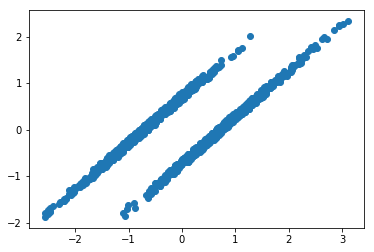

In [280]:
# Convert the categorical variables to dummy variables
df['region'] = df['region'].astype('category').cat.codes
df['type'] = df['type'].astype('category').cat.codes
df['year'] = df['Date'].astype('category').cat.codes

# Stack the columns
X = np.column_stack((df['type'], df['year'], df['region']))
X = sm.add_constant(X)

# Build and fit the model using ordinary least squares
model = sm.OLS(np.asarray(df['AveragePrice']), X)
results = model.fit()
print(results.summary())

plt.figure()
plt.scatter(df['AveragePrice'], results.resid)
plt.show()

The p-value for the `region` column is `0.379`, which means it can be dropped. Next a few combinations of numeric variables will be added and removed to improve the accuracy of the model. The residuals graph shows two parallel lines, which could be a sign of moderation. 

In [286]:
# Convert the categorical variables to dummy variables
df['region'] = df['region'].astype('category').cat.codes
df['type'] = df['type'].astype('category').cat.codes
df['Date'] = df['Date'].astype('category').cat.codes

# Stack the columns
X = np.column_stack((df['type'], df['year'], pd.to_numeric(df['4046']), pd.to_numeric(df['4225'])))
X = sm.add_constant(X)

# Split the data into test/train sets to prevent overfitting
# and test predictions on the model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df['AveragePrice'], test_size=0.1)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1166, 5) (130, 5)
(1166,) (130,)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     351.7
Date:                Sun, 28 Oct 2018   Prob (F-statistic):          2.51e-198
Time:                        17:33:12   Log-Likelihood:                -1199.9
No. Observations:                1166   AIC:                             2410.
Df Residuals:                    1161   BIC:                             2435.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6250      0.044    -14.268      0.0

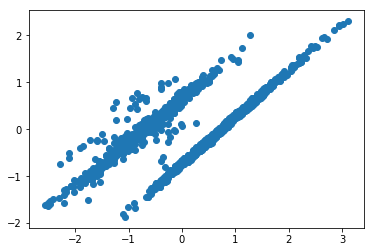

In [287]:
# Build and fit the model using ordinary least squares
model = sm.OLS(np.asarray(y_train), X_train)
results = model.fit()
print(results.summary())


plt.figure()
plt.scatter(y_train, results.resid)
plt.show()

The best `R-squared` value I was able to achieve was `0.545`, meaning that this model explains 54.5% of the variance of the dependent variable. 

In [290]:
# Predict results based on the X test set
predictions = results.predict(X_test)

# Show a table of actual vs predicted results
pd.DataFrame(data={'predictions': predictions, 'actual': y_test})

,predictions,actual
8639,-0.715569,-0.776606
17635,0.792449,0.138853
17796,0.695894,0.269632
8749,-1.109881,-2.019013
17890,0.669142,0.073463
17685,0.657388,1.381260
8631,-0.626206,-0.613131
17726,0.723128,0.302327
18169,0.709742,0.956226
18238,0.668969,0.694667


In [249]:
# fig, ax = plt.subplots()
# fig = sm.graphics.plot_fit(results, 0, ax=ax)
# plt.show()